# Relatório de cadastro de WF

In [51]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
import datetime
from itertools import groupby

pd.options.mode.chained_assignment = None  # default='warn'

In [52]:
arquivo = '09 08 2021.xlsx'

In [53]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [54]:
def cmap_bann():   
    lista_cores = ['lightsteelblue','royalblue','darkblue']   
    n_bin = 20   
    cmap_name = 'cmap_bann'
    cmap = LinearSegmentedColormap.from_list(cmap_name, lista_cores, N=n_bin)

    return cmap

def pallete_bann(df,coluna,pallete_cor):
    pal = sns.color_palette(pallete_cor, len(df))
    rank = df[coluna].argsort().argsort() 
    pallete = np.array(pal[::-1])[rank]
    
    return pallete
    

In [55]:
###Teste
df_ooo = pd.read_excel(arquivo,
                  sheet_name='Base Geral')

In [56]:
df = df_ooo

#df = df[['Área','Pendente']]
df = df.iloc[::-1]
df.index = range(0,df.shape[0])

for i, row in df.iterrows():
    if pd.isnull(row['Área']):
        df.loc[df.index==i+1,'Pendente'] = df['Pendente'].tolist()[i+1] + '\n' + df['Pendente'].tolist()[i]

df = df.dropna(subset=['Área'])

df = df.iloc[::-1]
df.index = range(0,df.shape[0])


df = df.fillna(method="ffill")


df_ooo = df



In [57]:
df = df_ooo

df['Dias em Atraso'] = datetime.datetime.today() - df['Data de Entrada']
df['Dias em Atraso'] = df['Dias em Atraso'] / np.timedelta64(1, 'D')

df = df[['Pendente','Área','Dias em Atraso']]

df['Maior que 3 dias'] = 0
df['Com Atraso'] = 0
df['Sem Atraso'] = 0

df.loc[df['Dias em Atraso']>=4,'Maior que 3 dias'] = 1
df.loc[(df['Dias em Atraso']>=2)&(df['Dias em Atraso']<4),'Com Atraso'] = 1
df.loc[df['Dias em Atraso']<2,'Sem Atraso'] = 1

df['verde'] = df['Maior que 3 dias']+df['Com Atraso']+df['Sem Atraso']
df['amarelo'] = df['Maior que 3 dias']+df['Com Atraso']
df['vermelho'] = df['Maior que 3 dias']


df_preparado = df

### 1. Pending by Areas

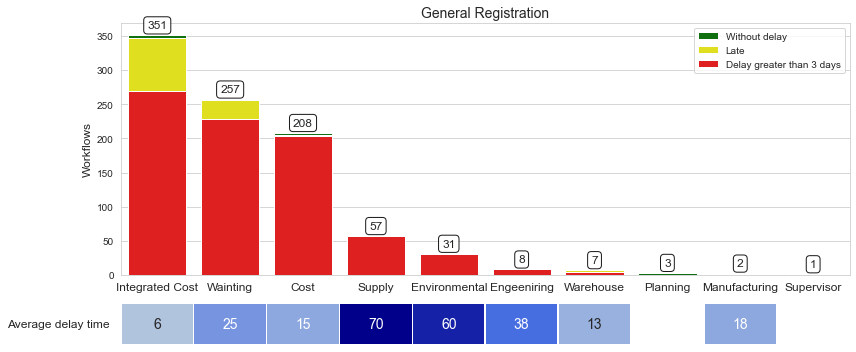

In [58]:
gridsize = (5,1)

fig = plt.figure(figsize=(12, 5))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=4)
ax2 = plt.subplot2grid(gridsize, (4, 0), colspan=1, rowspan=1)

df = df_preparado

df = df.groupby(['Área']).sum()
df = df.reset_index()
df = df.sort_values(by=['verde'],ascending=False)
ordem = df['Área'].tolist()


sns.set_style('whitegrid')
sns.barplot(x='Área',y='verde',data=df,ax=ax1,order=ordem,color = 'green',label='Without delay')


for p in ax1.patches:
    ax1.annotate(p.get_height().astype(int), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center',
                   va = 'center', 
                   size=12,
                   xytext = (0, + 10), 
                   textcoords = 'offset points',
                   bbox=dict(boxstyle='round', fc='w',ec='k',alpha=0.9),                      
                  )
    
sns.barplot(x='Área',y='amarelo',data=df,ax=ax1,order=ordem,color = 'yellow',label='Late')
sns.barplot(x='Área',y='vermelho',data=df,ax=ax1,order=ordem,color = 'red',label='Delay greater than 3 days')

ax1.legend(bbox_to_anchor= (1, 1),loc='upper right' )

ax1.set_xticklabels(ax1.get_xticklabels(),rotation=0, ha='center', fontsize = 12)
titulo = 'General Registration'
ax1.set_title(titulo, fontsize=14)
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Workflows', fontsize=12)

######################################
df = df_preparado

df = df.loc[df['amarelo']==1]

df = df.groupby(['Área']).mean()
df_ordem = pd.DataFrame(index=ordem)
df = pd.concat([df_ordem, df], axis=1, join="outer")
df.index.name = 'Área'
#df = df.reset_index()

df = df[['Dias em Atraso']]
df = df.T

#df = df.fillna(0)

sns.heatmap(df,
            linewidths=.5,
            ax=ax2,
            cmap=cmap_bann(),
            annot=True,
            fmt='.0f',
            cbar = False,
            annot_kws={"fontsize":14}
            )


ax2.set(xticklabels=[])
ax2.set(yticklabels=[])

ax2.set_ylabel('Average delay time',rotation=0, fontsize=12,ha='right',va='center')
ax2.set_xlabel('', fontsize=12)

fig.tight_layout()



### 2. Pending by People

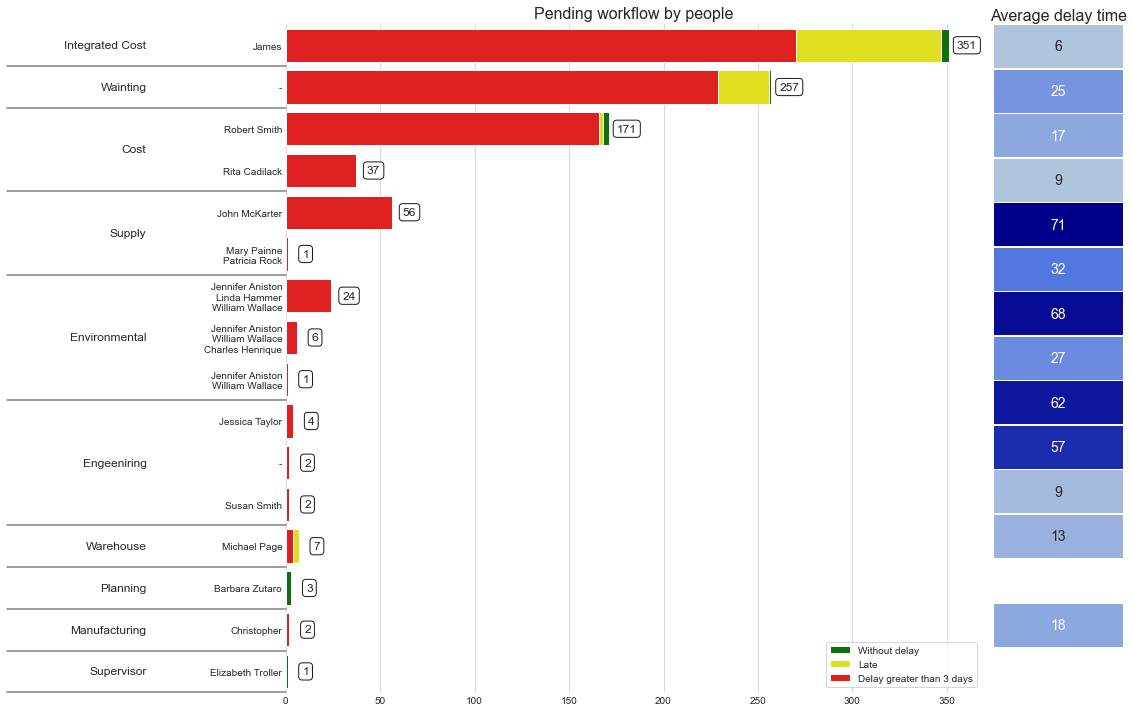

In [59]:
gridsize = (1,6)
fig = plt.figure(figsize=(15, 10))
#ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 0), colspan=5, rowspan=1)
ax3 = plt.subplot2grid(gridsize, (0, 5), colspan=1, rowspan=1)

df = df_preparado

df = df.groupby(['Área','Pendente']).sum()
df = df.reset_index()

df['area_ordem'] = pd.Categorical(df['Área'], ordem)
df = df.sort_values(by=['area_ordem','verde'],ascending=[True, False])

df = df.set_index(['area_ordem','Pendente'])
df_graf = df.iloc[::-1]
df = df.reset_index()

df_ordem = pd.DataFrame(index=df['Pendente'])

df['aux1'] = range(0,df.shape[0])
df['aux1'] = df['aux1'].astype(str)
df_aux = df
sns.barplot(x='verde',y='aux1',data=df,ax=ax2,color = 'green',label='Without delay')

for p in ax2.patches:
    ax2.annotate(p.get_width().astype(int), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha = 'center',
                   va = 'center', 
                   size=12,
                   xytext = (+18, 0), 
                   textcoords = 'offset points',
                   bbox=dict(boxstyle='round', fc='w',ec='k',alpha=0.9),                      
                  )
    
sns.barplot(x='amarelo',y='aux1',data=df,ax=ax2,color = 'yellow',label='Late')
sns.barplot(x='vermelho',y='aux1',data=df,ax=ax2,color = 'red', label='Delay greater than 3 days')

ax2.legend(bbox_to_anchor= (1, 0),loc='lower right' )

ax2.set_yticklabels(df['Pendente'],fontsize=10)
####################################################################################

# escreve multi index no grafico

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def add_line(ax, ypos):
    line = plt.Line2D([-.4, 0],[ypos, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

escala = 1./df_graf.index.size
pos=0
for label, rpos in label_len(df_graf.index,0):
    ypos = (pos + .5 * rpos)*escala
    ax2.text( -.2, ypos, label, ha='right',va='center', transform=ax2.transAxes,fontsize=12)
    add_line(ax2,pos*escala)
    pos += rpos

    
            
####################################################################################
#ax1.set_xticklabels(ax1.get_xticklabels(),rotation=60, ha='right', fontsize = 14)
titulo = 'Pending workflow by people'
ax2.set_title(titulo, fontsize=16)
ax2.set_xlabel('', fontsize=12)
ax2.set_ylabel('', fontsize=12)


sns.despine(left=True, bottom=True)
ax2.tick_params(axis=u'both', which=u'both', length=0)

 
    
# Texto acima da barra


##################################################################
df = df_preparado

df = df.loc[df['amarelo']==1]


df = df[['Pendente','Dias em Atraso']]
df = df.groupby(['Pendente']).mean()

df = pd.concat([df_ordem, df], axis=1, join="inner")
df = df.reset_index()

df['aux'] = 0
tabela = pd.pivot_table(df, values = 'Dias em Atraso', index=['Pendente'],columns=['aux'], aggfunc=np.mean)

tabela = pd.concat([df_ordem, tabela], axis=1, join="outer")

sns.heatmap(tabela,
            linewidths=.5,
            ax=ax3,
            cmap=cmap_bann(),
            annot=True,
            fmt='.0f',
            cbar = False,
            annot_kws={"fontsize":14}
            )


ax3.set(xticklabels=[])
ax3.set(yticklabels=[])

ax3.set_xlabel('Average delay time',rotation=0, fontsize=16,ha='center',va='center')
ax3.xaxis.set_label_position('top') 
ax3.set_ylabel('', fontsize=12)

    
fig.tight_layout()

None